In [1]:
import mdsine2 as md2
from mdsine2.names import STRNAMES
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path

[DEBUG] Using default logger (stdout, stderr).


# McNulty et al., 2013 
# LF/HPP ==> HF/HS ==> LF/HPP

In [2]:
# Define the output directory
output_dir = Path('mcnulty-results/LF0')

## Create MDSINE2 Study object from input datasets

In [3]:
# Parse tables of samples and cast in Subject sets. Automatically creates the subject classes with the respective names. {dataset.py, pylab/base.py}
mcnulty_lf0 = md2.dataset.parse(                                # Parse a dataset. Acts as a wrapper for mdsine2.Study.parse
    name='mcnulty_lf0',                                         # Name of the dataset
    metadata='mcnulty-datasets/LF0/metadata.tsv',               # Metadata file
    taxonomy='mcnulty-datasets/LF0/taxonomy.tsv',               # Taxonomy file
    reads='mcnulty-datasets/LF0/reads.tsv',                     # Reads file
    qpcr='mcnulty-datasets/LF0/dna_yields.tsv',                 # qPCR file
    perturbations='mcnulty-datasets/LF0/perturbations.tsv',     # Perturbations file 
    sep='\t'                                                    # Separator used in the input files
)

[INFO] TaxaSet parsng new taxonomy table. Resetting
[INFO] No `name` found - assuming index is the name
[DEBUG] Reseting perturbations


## Visualize abundance over time and perturbation recurrence

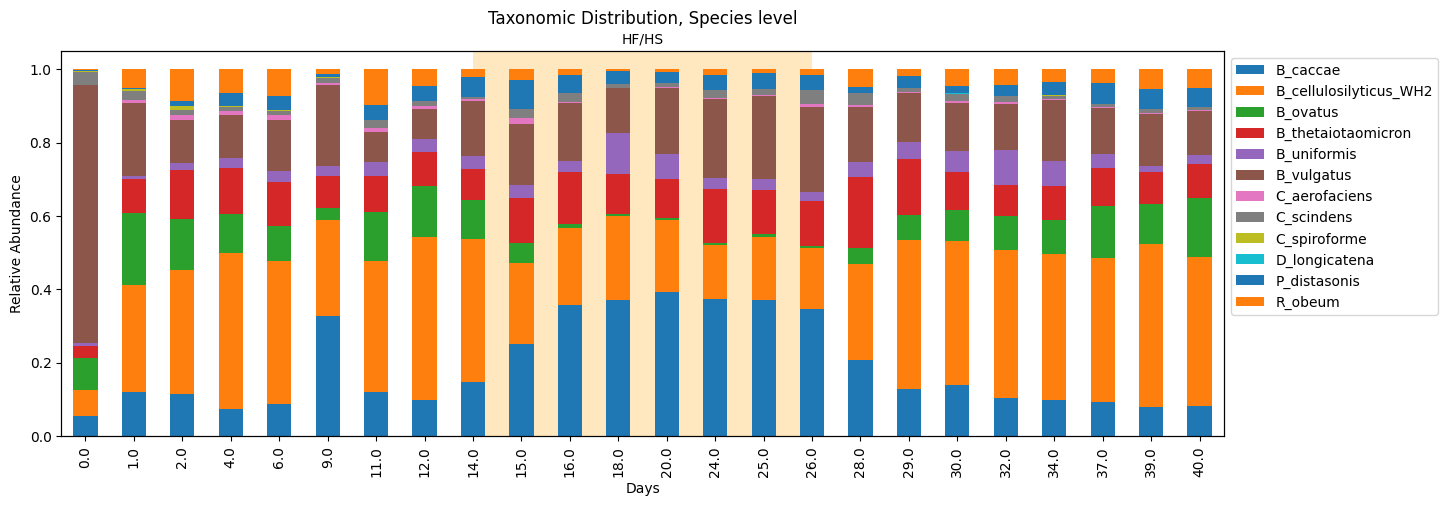

In [4]:
# Plot the taxa abundances at the species level for subject `1` {visualization.py}
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
md2.visualization.taxonomic_distribution_over_time(         # Produces a taxonomic bar graph for each datapoint
    mcnulty_lf0['1'],                                       # Subject we are getting the data from
    taxlevel='species',                                     # This is the taxonomic level to aggregate the data at
    label_formatter='%(name)s',                             # If specified, it will tell how to make the legend using the taxaname_formatter
    ax=ax                                                   # Axis to plot on
)
plt.show()

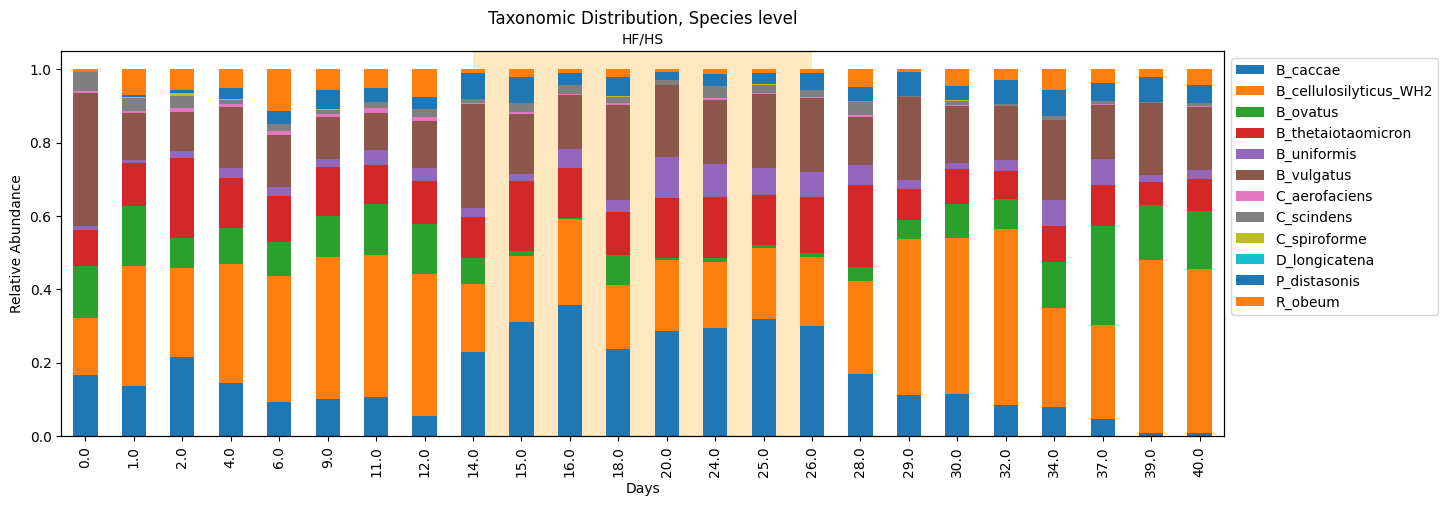

In [5]:
# Plot the taxa abundances at the species level for subject `7` {visualization.py}
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
md2.visualization.taxonomic_distribution_over_time(
    mcnulty_lf0['7'],                              
    taxlevel='species',                            
    label_formatter='%(name)s',                    
    ax=ax                                          
)
plt.show()

## Learning the Negative Binomial dispersion parameters

Before running the main inference loop we learn the negative binomial parameters ($d_0$, $d_1$) from our physical replicates

In [6]:
# Set negative binomial model inference parameters
# Configuration class for learning the negative binomial dispersion parameters. Note that these parameters are learned offline. {config.py}
params_lf0 = md2.config.NegBinConfig(       # Initialize the MCMC chain (NegBinConfig class)
    seed=0,                                 # Seed to start the inference
    burnin=100,                             # Number of initial Gibbs steps to throw away (burn-in iterations)
    n_samples=1000,                         # Number of total Gibbs steps (total iterations)
    checkpoint=100,                         # How often to write the trace in RAM to disk. Note that this must be a multiple of both burnin and n_samples
    basepath=str(output_dir / "negbin")     # Basepath to save the trace to disk
)

In [7]:
# Build the compute graph for learning the model that is used to learn negative binomial parameters {negbin.py}
mcmc_negbin_lf0 = md2.negbin.build_graph(       # Builds the graph used for posterior inference of the negative binomial dispersion parameters (mdsin2.BaseMCMC)
    params=params_lf0,                          # Parameters to run the model
    graph_name=mcnulty_lf0.name,                # Name (label) of the graph
    subjset=mcnulty_lf0                         # Subject (MDSINE2.Study object)
)

[DEBUG] Available subjects: 1,2,3,4,5,6,7
[DEBUG] Subject 1, available qpcr: 0.0,1.0,2.0,4.0,6.0,9.0,11.0,12.0,14.0,15.0,16.0,18.0,20.0,24.0,25.0,26.0,28.0,29.0,30.0,32.0,34.0,37.0,39.0,40.0
[DEBUG] Subject 2, available qpcr: 0.0,1.0,2.0,4.0,6.0,9.0,11.0,12.0,14.0,15.0,16.0,18.0,20.0,24.0,25.0,26.0,28.0,29.0,30.0,32.0,34.0,37.0,39.0,40.0
[DEBUG] Subject 3, available qpcr: 0.0,1.0,2.0,4.0,6.0,9.0,11.0,12.0,14.0,15.0,16.0,18.0,20.0,24.0,25.0,26.0,28.0,29.0,30.0,32.0,34.0,37.0,39.0,40.0
[DEBUG] Subject 4, available qpcr: 0.0,1.0,2.0,4.0,6.0,9.0,11.0,12.0,14.0,15.0,16.0,18.0,20.0,24.0,25.0,26.0,28.0,29.0,30.0,32.0,34.0,37.0,39.0,40.0
[DEBUG] Subject 5, available qpcr: 0.0,1.0,2.0,4.0,6.0,9.0,11.0,12.0,14.0,15.0,16.0,18.0,20.0,24.0,25.0,26.0,28.0,29.0,30.0,32.0,34.0,37.0,39.0,40.0
[DEBUG] Subject 6, available qpcr: 0.0,1.0,2.0,4.0,6.0,9.0,11.0,12.0,14.0,15.0,16.0,18.0,20.0,24.0,25.0,26.0,28.0,29.0,30.0,32.0,34.0,37.0,39.0,40.0
[DEBUG] Subject 7, available qpcr: 0.0,1.0,2.0,4.0,6.0,9.0,11.0,

In [8]:
# Run inference to learn the negative binomial parameters {negbin.py, run.py, pylab/inferenec.py}
mcmc_negbin_lf0 = md2.negbin.run_graph(     # Run the MCMC chain mcmc (mdsin2.BaseMCMC)
    mcmc_negbin_lf0,                        # Inference object that is already built and initialized (mdsine2.BaseMCMC)
    crash_if_error=True)                    # If True, throws an error if there is an exception during inference.

 10%|▉         | 97/1000 [00:01<00:12, 74.40it/s][DEBUG] Inference iteration 100/1000, time: 1.716392993927002
[DEBUG] Negative binomial dispersion a0: Value: 1.9465546447209898e-10, Acceptance rate: 1.0
[DEBUG] Negative binomial dispersion a1: Value: 0.5008475442330831, Acceptance rate: 0.46
[DEBUG] Filtering: no-mp : Time: 0.0121, Acc: [0.417, 0.333, 0.333, 0.333, 0.333, 0.250, 0.417], data/sec: 6950.38
 19%|█▉        | 193/1000 [00:03<00:11, 71.90it/s][DEBUG] Inference iteration 200/1000, time: 1.397766351699829
[DEBUG] Negative binomial dispersion a0: Value: 1.3460452585217842e-10, Acceptance rate: 1.0
[DEBUG] Negative binomial dispersion a1: Value: 0.64404365705479, Acceptance rate: 0.8
[DEBUG] Filtering: no-mp : Time: 0.0124, Acc: [0.667, 0.667, 0.583, 0.250, 0.500, 0.333, 0.500], data/sec: 6753.85
 30%|██▉       | 297/1000 [00:04<00:09, 71.11it/s][DEBUG] Inference iteration 300/1000, time: 1.4023568630218506
[DEBUG] Negative binomial dispersion a0: Value: 2.5098817139196567e-10,

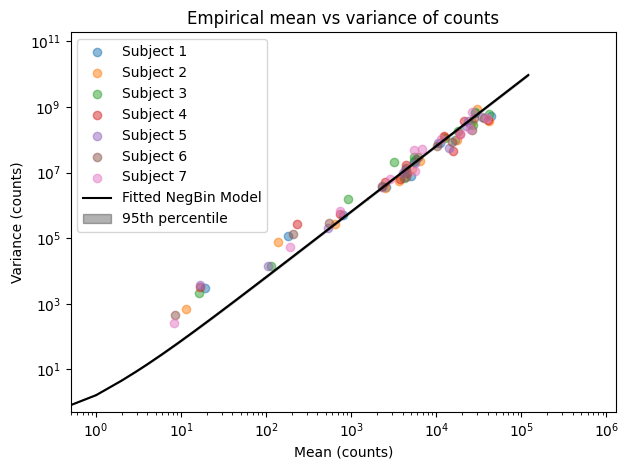

In [9]:
# Visualize the negative binomial dispersion model {negbin.py, visualization.py}
fig = md2.negbin.visualize_learned_negative_binomial_model(
    mcmc_negbin_lf0                         # Inference object with the negative binomial posteriors and the data it was learned on (mdsine2.BaseMCMC) 
)
fig.tight_layout()
plt.show()

In [10]:
# Summary of d0 and d1 posterior
print('a0', md2.summary(mcmc_negbin_lf0.graph[STRNAMES.NEGBIN_A0])) # d0
print('a1', md2.summary(mcmc_negbin_lf0.graph[STRNAMES.NEGBIN_A1])) # d1

a0 {'median': 1.2393166297743567e-10, 'mean': 1.3628458006955444e-10, '25th percentile': 7.992260196202748e-11, '75th percentile': 1.9706061755274507e-10}
a1 {'median': 0.6440948351455769, 'mean': 0.6417000832583004, '25th percentile': 0.6293286312851858, '75th percentile': 0.6593384564511456}


## Run inference on the full model

In [11]:
# Get a0 and a1 from negbin (get the mean of the posterior) and fixes them for inference {negbin.py, config.py, pylab/variables.py}
a0_lf0 = md2.summary(mcmc_negbin_lf0.graph[STRNAMES.NEGBIN_A0])['mean']
a1_lf0 = md2.summary(mcmc_negbin_lf0.graph[STRNAMES.NEGBIN_A1])['mean']

print('negbin a0', a0_lf0)
print('negbin a1', a1_lf0)

negbin a0 1.3628458006955444e-10
negbin a1 0.6417000832583004


### Set por running inference with with SEED=0

In [12]:
# Set directory
basepath_s0 = output_dir / "mdsine2" / "seed0"
basepath_s0.mkdir(exist_ok=True, parents=True)

In [13]:
# Initialize parameters of the model
params_lf0_s0 = md2.config.MDSINE2ModelConfig(
    basepath=str(basepath_s0),                  # Basepath to save the inference trace to disk
    seed=0,                                     # Seed to start the inference
    burnin=100,                                 # Number of initial Gibbs steps to throw away (burn-in iterations)
    n_samples=1000,                             # Number of total Gibbs steps (total iterations)
    negbin_a0=a0_lf0, negbin_a1=a1_lf0,         # Negative binomial dispersion parameters   
    checkpoint=100                              # How often to write the trace in RAM to disk. Note that this must be a multiple of both burnin and n_samples
)

In [14]:
# Initialize the clustering choice {config.py, pylab/variables.py}
params_lf0_s0.INITIALIZATION_KWARGS[STRNAMES.CLUSTERING]['value_option'] = 'no-clusters'
# Other options: 'spearman', , 'no-clusters', 'fixed-clustering', 'manual', 'random', 'taxonomy'

In [15]:
# Builds the graph with the posterior classes and creates an mdsine2.BaseMCMC inference chain object that you ran run inference with {run.py}
mcmc_lf0_s0 = md2.initialize_graph(         # Return pylab.inference.BaseMCMC
    params=params_lf0_s0,                   # Parameters to run the model (MDSINE2ModelConfig class)
    graph_name=mcnulty_lf0.name,            # Name (label) of the graph
    subjset=mcnulty_lf0                     # Subject (MDSINE2.Study object)
)

[INFO] max_value found: 1304402561.1345034, scaling_factor: 7.666344959720491e-08
[INFO] Normalizing abundances for a max value of 100. Normalization constant: 7.6663E-08
[INFO] There are 168 qPCR measurements for 3 buckets. Each bucket is 56 measurements long
[INFO] Initializing Filtering
[INFO] Setting up the essential timepoints
[INFO] Essential timepoints: [ 0.  1.  2.  4.  6.  9. 11. 12. 14. 15. 16. 18. 20. 24. 25. 26. 28. 29.
 30. 32. 34. 37. 39. 40.]
[INFO] Initializing Zero inflation


[WARNING] `zero_inflation_transition_policy` is None so we are not doing anything


[INFO] Initializing LHS vector
[INFO] Initializing growth design matrix
[INFO] Initializing self-interactions design matrix
[INFO] Initializing Clustering concentration parameter
[INFO] Cluster Concentration initialization results:
	prior shape: 1e-05
	prior scale: 100000.0
	value: 1.0
[INFO] Initializing Clustering parameter
[INFO] Cluster Assingments initialization results:
Clustering object (contains ability to change the cluster assignments), n_clusters: 12
Cluster 100112
	members: ['B_caccae']
	size: 1
Cluster 100113
	members: ['B_cellulosilyticus_WH2']
	size: 1
Cluster 100114
	members: ['B_ovatus']
	size: 1
Cluster 100115
	members: ['B_thetaiotaomicron']
	size: 1
Cluster 100116
	members: ['B_uniformis']
	size: 1
Cluster 100117
	members: ['B_vulgatus']
	size: 1
Cluster 100118
	members: ['C_aerofaciens']
	size: 1
Cluster 100119
	members: ['C_scindens']
	size: 1
Cluster 100120
	members: ['C_spiroforme']
	size: 1
Cluster 100121
	members: ['D_longicatena']
	size: 1
Cluster 100122
	mem

### Perform inference

In [16]:
# Perform inference
mcmc_lf0_s0 = md2.run_graph(    # Run the MCMC chain mcmc (mdsin2.BaseMCMC)
    mcmc_lf0_s0,                # Inference object that is already built and initialized (mdsine2.BaseMCMC)
    crash_if_error=True         # If True, throws an error if there is an exception during inference.
)

 10%|█         | 100/1000 [00:13<01:46,  8.46it/s][DEBUG] Inference iteration 100/1000, time: 13.2793128490448
[DEBUG] Cluster interaction indicator parameter: [False False]
total time: 0.0021049976348876953, n_interactions: 0/2, 0.00
[DEBUG] Cluster interaction probability: [ClusterInteractionIndicatorProbability(0.052383170795929336)]
[DEBUG] Perturbation indicator parameter: Perturbation Indicators - time: 0.002034902572631836s
perturbation HF/HS (1/2): [ True False]
[DEBUG] Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation HF/HS: 0.1712960076464146
[DEBUG] Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.34633261 0.5128992  0.39799088 0.47786459 0.49926208 0.36082716
 0.55454949 0.53000612 0.17582504 0.03813027 0.78068158 0.35174278]
Self Interactions:
[0.06496789 0.03827081 0.09498049 0.13411073 0.34257397 0.07016081
 2.8774631  1.116303   7.01823291 1.7

### Visualize posteriors

Growth rates

B_caccae: 0.3169097952135603
B_cellulosilyticus_WH2: 0.44525215836250676
B_ovatus: 0.6610305051516627
B_thetaiotaomicron: 0.6422186114347157
B_uniformis: 0.3843364744422966
B_vulgatus: 0.4253679755684926
C_aerofaciens: 0.4435621767440279
C_scindens: 0.4294143587146766
C_spiroforme: 0.16546203237015944
D_longicatena: 0.040636820796319376
P_distasonis: 0.5354105308494466
R_obeum: 0.5963569640509283


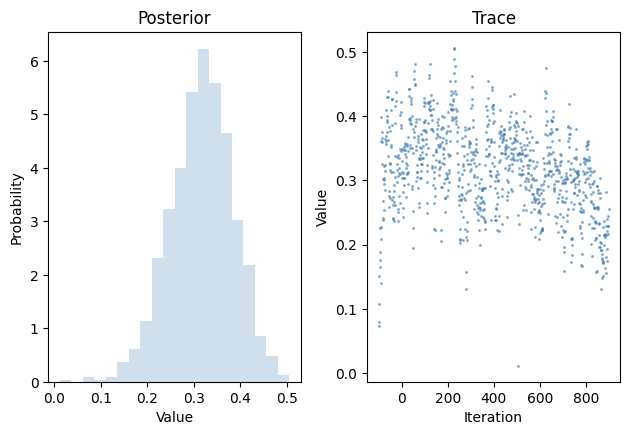

In [17]:
# Get the trace of the growth rates {names.py, config.py, posterior.py}
growth_lf0_s0 = mcmc_lf0_s0.graph[STRNAMES.GROWTH_VALUE]
growth_rates_trace_lf0_s0 = growth_lf0_s0.get_trace_from_disk(section='entire')

# Get the mean of the growth rates for each taxa {pylab/variables.py}
growth_rates_mean_lf0_s0 = md2.summary(growth_lf0_s0)['mean']
for i in range(growth_rates_mean_lf0_s0.shape[0]):
    print(f'{mcnulty_lf0.taxa[i].name}: {growth_rates_mean_lf0_s0[i]}')

# Visualize trace for the first taxa {visualization.py}
md2.visualization.render_trace(         # Visualizes the Trace of a random variable
    growth_rates_trace_lf0_s0[:,0],     # Trace of the growth rates for the first taxa
    n_burnin=100                        # Tells how big the burnin array is
)
plt.show()

Taxa module assignments

[ERROR] 25th percentile failed
[ERROR] 75th percentile failed


[INFO] Number of clusters: 3
[INFO] Clusters assigned: [0 1 1 0 0 0 0 0 0 2 1 1]


[ERROR] 25th percentile failed
[ERROR] 75th percentile failed


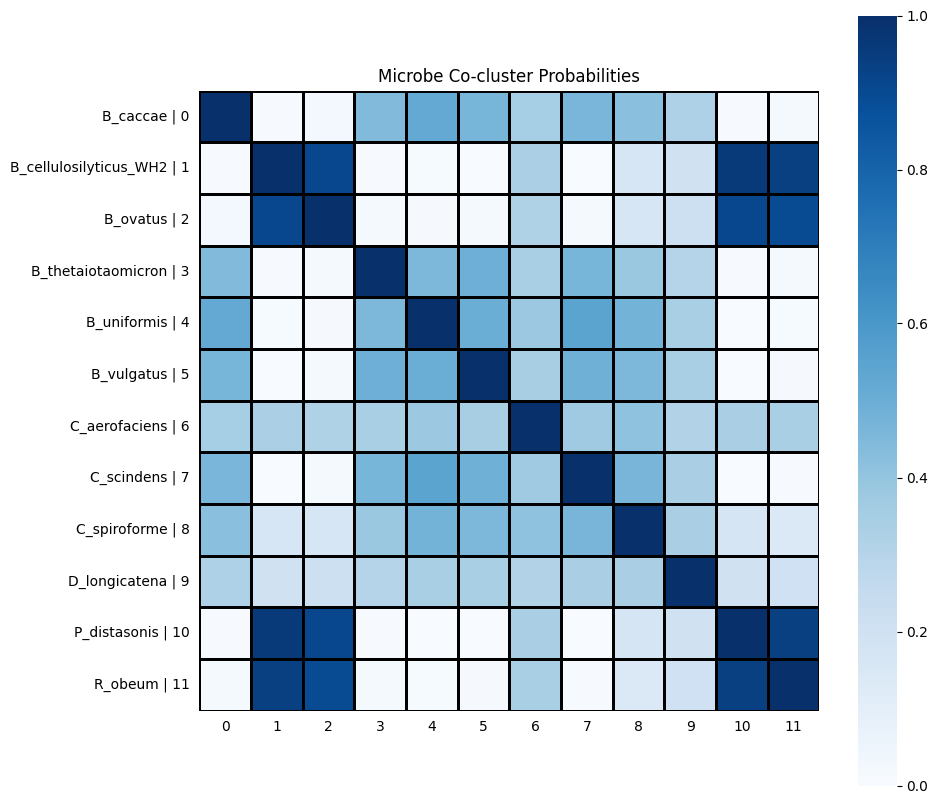

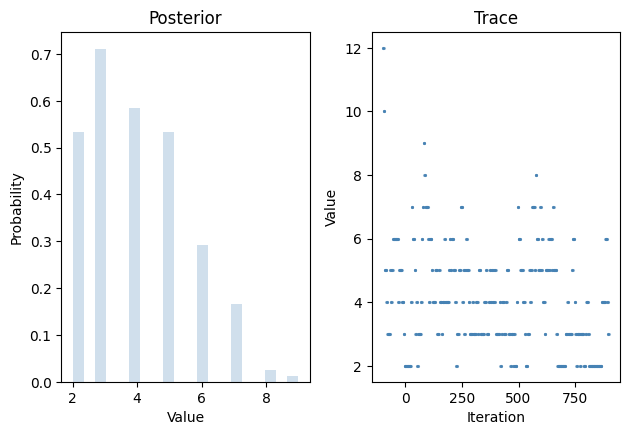

In [18]:
# Get the clustering assignments and probabilities  {names.py, posterior.py, util.py, pylab/cluster.py}
clustering_lf0_s0 = mcmc_lf0_s0.graph[STRNAMES.CLUSTERING_OBJ]
# Once the inference is complete, compute the clusters posthoc using sklearn's AgglomerativeClustering function with distance matrix being 1 - cocluster matrix
md2.generate_cluster_assignments_posthoc(       # Returns np.ndarray(size=(len(items), ), dtype=int)
    clustering_lf0_s0,                          # Clustering object (mdsine2.posterior.Clustering)
    # n_clusters=2,                             # This specifies the number of clusters that are used during Agglomerative clustering.
    set_as_value=True                           # If True then set the result as the value of the clustering object
)

# Get the taxa from the graph
taxa = mcmc_lf0_s0.graph.data.taxa

# Visualize co-cluster posterior probability {posterior.py, visualization.py}
coclusters_lf0_s0 = md2.summary(mcmc_lf0_s0.graph[STRNAMES.CLUSTERING_OBJ].coclusters)['mean']  # Get the mean of the cocluster posterior
md2.visualization.render_cocluster_probabilities(   # Render the cocluster proportions. Values in coclusters should be [0,1]
    coclusters_lf0_s0, taxa=mcnulty_lf0.taxa,       # Square matrix indicating the cocluster proportions (2-dim np.ndarray)
    yticklabels='%(name)s | %(index)s')             # Label for the y-axis (str)

# Visualize trace for number of modules
md2.visualization.render_trace(         # Visualizes the Trace of a random variable
    clustering_lf0_s0.n_clusters        # Trace of the co-clustering probabilities
)
plt.show()

**IMPORTANT:** All model parameters have traces and can be visualized in a similar fashion. All `STRNAMES` can be found in names.py. Also check posterior.py

### Run inference on the full model again, but with a different seed (seed=1)

In [19]:
# Set directory
basepath_s1 = output_dir / "mdsine2" / "seed1"
basepath_s1.mkdir(exist_ok=True, parents=True)

# Initialize parameters of the model
params_lf0_s1 = md2.config.MDSINE2ModelConfig(
    basepath=str(basepath_s1),            
    seed=1,                            
    burnin=100,                        
    n_samples=1000,                    
    negbin_a0=a0_lf0, negbin_a1=a1_lf0,
    checkpoint=100                     
)

# Initialize the clustering choice
params_lf0_s1.INITIALIZATION_KWARGS[STRNAMES.CLUSTERING]['value_option'] = 'no-clusters'

# Builds the graph with the posterior classes and creates an mdsine2.BaseMCMC inference chain object that you ran run inference with
mcmc_lf0_s1 = md2.initialize_graph(
    params=params_lf0_s1,          
    graph_name=mcnulty_lf0.name,   
    subjset=mcnulty_lf0            
)

# Perform inference
mcmc_lf0_s1 = md2.run_graph(
    mcmc_lf0_s1,            
    crash_if_error=True     
)

[INFO] max_value found: 1304402561.1345034, scaling_factor: 7.666344959720491e-08
[INFO] Normalizing abundances for a max value of 100. Normalization constant: 7.6663E-08
[INFO] There are 168 qPCR measurements for 3 buckets. Each bucket is 56 measurements long
[INFO] Initializing Filtering
[INFO] Setting up the essential timepoints
[INFO] Essential timepoints: [ 0.  1.  2.  4.  6.  9. 11. 12. 14. 15. 16. 18. 20. 24. 25. 26. 28. 29.
 30. 32. 34. 37. 39. 40.]
[INFO] Initializing Zero inflation


[WARNING] `zero_inflation_transition_policy` is None so we are not doing anything


[INFO] Initializing LHS vector
[INFO] Initializing growth design matrix
[INFO] Initializing self-interactions design matrix
[INFO] Initializing Clustering concentration parameter
[INFO] Cluster Concentration initialization results:
	prior shape: 1e-05
	prior scale: 100000.0
	value: 1.0
[INFO] Initializing Clustering parameter
[INFO] Cluster Assingments initialization results:
Clustering object (contains ability to change the cluster assignments), n_clusters: 12
Cluster 100112
	members: ['B_caccae']
	size: 1
Cluster 100113
	members: ['B_cellulosilyticus_WH2']
	size: 1
Cluster 100114
	members: ['B_ovatus']
	size: 1
Cluster 100115
	members: ['B_thetaiotaomicron']
	size: 1
Cluster 100116
	members: ['B_uniformis']
	size: 1
Cluster 100117
	members: ['B_vulgatus']
	size: 1
Cluster 100118
	members: ['C_aerofaciens']
	size: 1
Cluster 100119
	members: ['C_scindens']
	size: 1
Cluster 100120
	members: ['C_spiroforme']
	size: 1
Cluster 100121
	members: ['D_longicatena']
	size: 1
Cluster 100122
	mem

### Visualize posteriors

B_caccae: 0.3064069642943009
B_cellulosilyticus_WH2: 0.4614540630090185
B_ovatus: 0.7281752488200165
B_thetaiotaomicron: 0.5363291387020311
B_uniformis: 0.3615221024828251
B_vulgatus: 0.2859647237524166
C_aerofaciens: 0.45866200820146535
C_scindens: 0.4775221924304963
C_spiroforme: 0.15838995212381976
D_longicatena: 0.035906488407996526
P_distasonis: 0.47185875913730224
R_obeum: 0.8034192364426959


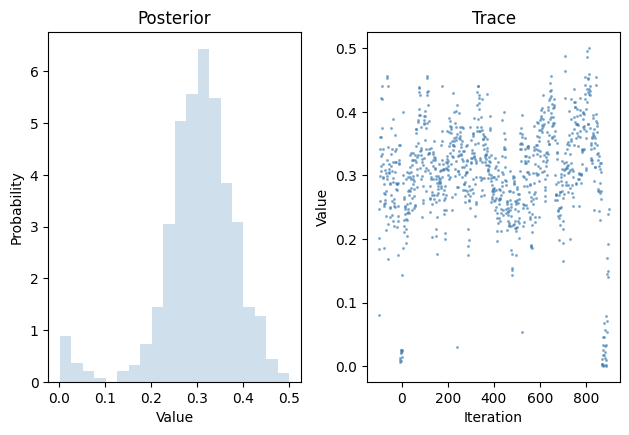

[ERROR] 25th percentile failed
[ERROR] 75th percentile failed


[INFO] Number of clusters: 3
[INFO] Clusters assigned: [0 1 1 0 0 0 1 0 0 2 1 1]


[ERROR] 25th percentile failed
[ERROR] 75th percentile failed


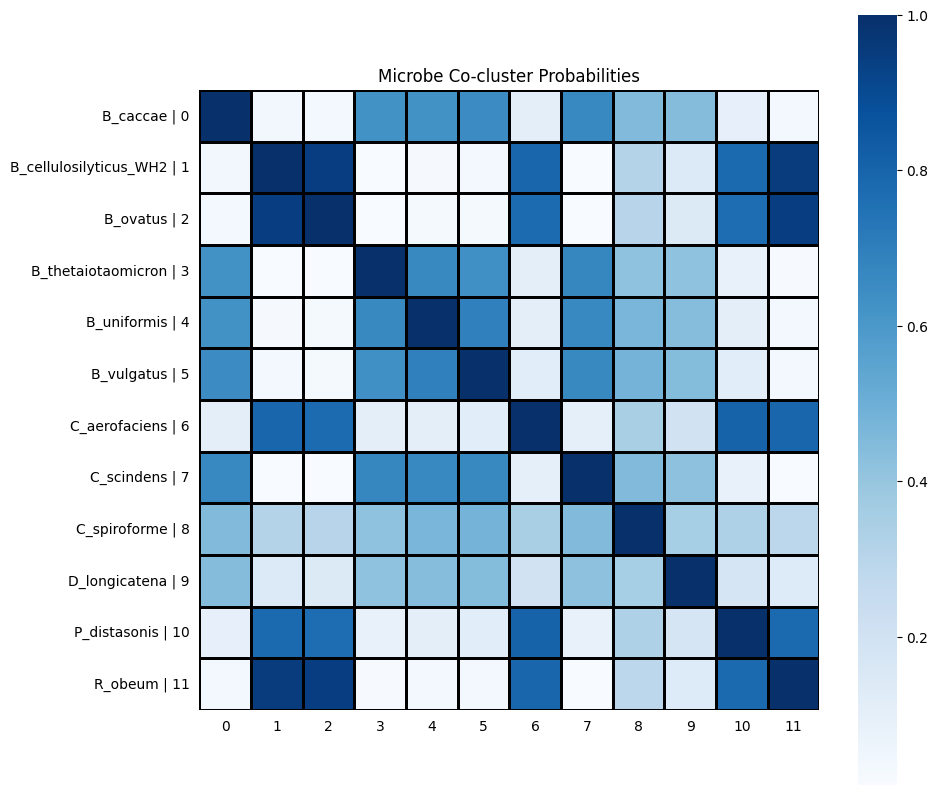

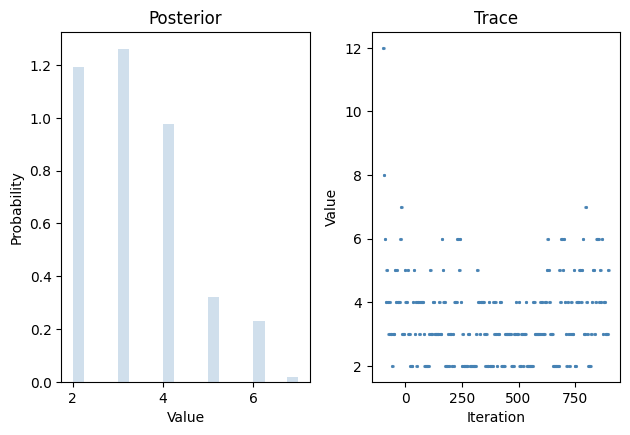

In [20]:
# Get the trace of the growth rates
growth_lf0_s1 = mcmc_lf0_s1.graph[STRNAMES.GROWTH_VALUE]
growth_rates_trace_lf0_s1 = growth_lf0_s1.get_trace_from_disk(section='entire')

# Get the mean of the growth rates for each taxa
growth_rates_mean_lf0_s1 = md2.summary(growth_lf0_s1)['mean']
for i in range(growth_rates_mean_lf0_s1.shape[0]):
    print(f'{mcnulty_lf0.taxa[i].name}: {growth_rates_mean_lf0_s1[i]}')

# Visualize trace for the first taxa
md2.visualization.render_trace(
    growth_rates_trace_lf0_s1[:,0],
    n_burnin=100
)
plt.show()

# Get the clustering assignments and probabilities 
clustering_lf0_s1 = mcmc_lf0_s1.graph[STRNAMES.CLUSTERING_OBJ]
md2.generate_cluster_assignments_posthoc(       
    clustering_lf0_s1,                         
    # n_clusters=2,                             
    set_as_value=True                           
)

# Get the taxa from the graph
taxa = mcmc_lf0_s1.graph.data.taxa 

# Visualize co-cluster posterior probability 
coclusters_lf0_s1 = md2.summary(mcmc_lf0_s1.graph[STRNAMES.CLUSTERING_OBJ].coclusters)['mean'] 
md2.visualization.render_cocluster_probabilities(   
    coclusters_lf0_s1, taxa=mcnulty_lf0.taxa,    
    yticklabels='%(name)s | %(index)s')           

# Visualize trace for number of modules
md2.visualization.render_trace(        
    clustering_lf0_s1.n_clusters       
)
plt.show()

## Compute [$\hat{r}$](https://www-jstor-org.ezproxy.uniandes.edu.co/stable/pdf/2246093.pdf?ab_segments=) statistic on model parameters to assess mixing

In [21]:
# Calculate the rhat statistic- It assesses mixing of the chains {pylab/inference.py}
chains_lf0 = [mcmc_lf0_s0, mcmc_lf0_s1]
start = 0
end = 1000

rhat_growth_rates_lf0 = md2.pylab.inference.r_hat(          # Computes the rhat for a variable in the chain
    chains_lf0,                                             # An iterable object of pylab.inference.BaseMCMC objects
    start=start,                                            # The start index of the chain to compute the rhat
    end=end,                                                # The end index of the chain to compute the rhat
    vname=STRNAMES.GROWTH_VALUE                             # The name of the variable to compute the rhat
)
print('Growth parameter r-hat:', rhat_growth_rates_lf0)

rhat_concentration_lf0 = md2.pylab.inference.r_hat(         # Computes the rhat for a variable in the chain
    chains_lf0,                                             # An iterable object of pylab.inference.BaseMCMC objects
    start=start,                                            # The start index of the chain to compute the rhat
    end=end,                                                # The end index of the chain to compute the rhat
    vname=STRNAMES.CONCENTRATION                            # The name of the variable to compute the rhat
)
print('Concentration parameter r-hat:', rhat_concentration_lf0)

rhat_processvar_lf0 = md2.pylab.inference.r_hat(            # Computes the rhat for a variable in the chain
    chains_lf0,                                             # An iterable object of pylab.inference.BaseMCMC objects
    start=start,                                            # The start index of the chain to compute the rhat
    end=end,                                                # The end index of the chain to compute the rhat
    vname=STRNAMES.PROCESSVAR                               # The name of the variable to compute the rhat
)
print('Process variance parameter r-hat:', rhat_processvar_lf0)

Growth parameter r-hat: [1.0212373  1.01157054 1.02306567 1.30124787 1.02791404 2.36144557
 1.01072612 1.05898625 1.00455757 1.01412274 1.06788358 1.17629406]
Concentration parameter r-hat: [2.89776886]
Process variance parameter r-hat: [9.31605177]


## Consensus clustering

Run the model with module assignments fixed (to their most likely module assignment learned from the previous step)

In [23]:
# Set directory
basepath_mxcl = output_dir / 'mdsine2-fixed-cluster'
basepath_mxcl.mkdir(exist_ok=True)

Use the clustering from a previous as the clustering assignment

In [25]:
# Initialize parameters of the model
params_mxcl_lf0 = md2.config.MDSINE2ModelConfig(
    basepath=basepath_mxcl, 
    seed=0, 
    burnin=100, 
    n_samples=1000, 
    negbin_a0=a0_lf0, negbin_a1=a1_lf0, 
    checkpoint=100
)

# Do not learn the clustering parameters
params_mxcl_lf0.LEARN[STRNAMES.CLUSTERING] = False
params_mxcl_lf0.LEARN[STRNAMES.CONCENTRATION] = False

# Set the initialization option for clustering (the ones that were already learned)
params_mxcl_lf0.INITIALIZATION_KWARGS[STRNAMES.CLUSTERING]['value_option'] = 'fixed-clustering'
params_mxcl_lf0.INITIALIZATION_KWARGS[STRNAMES.CLUSTERING]['value'] = str(basepath_s0 / "mcmc.pkl") # Most likely module assignment

# Initialize the graph
mcmc_mxcl_lf0 = md2.initialize_graph(
    params=params_mxcl_lf0, 
    graph_name=mcnulty_lf0.name, 
    subjset=mcnulty_lf0
)
# Run inference
mcmc_mxcl_lf0 = md2.run_graph(
    mcmc_mxcl_lf0, 
    crash_if_error=True
)

[WARNING] qPCR is already rescaled. unscaling and rescaling


[INFO] max_value found: 1304402561.1345034, scaling_factor: 7.666344959720491e-08
[INFO] Normalizing abundances for a max value of 100. Normalization constant: 7.6663E-08
[INFO] There are 168 qPCR measurements for 3 buckets. Each bucket is 56 measurements long
[INFO] Initializing Filtering
[INFO] Setting up the essential timepoints
[INFO] Essential timepoints: [ 0.  1.  2.  4.  6.  9. 11. 12. 14. 15. 16. 18. 20. 24. 25. 26. 28. 29.
 30. 32. 34. 37. 39. 40.]
[INFO] Initializing Zero inflation


[WARNING] `zero_inflation_transition_policy` is None so we are not doing anything


[INFO] Initializing LHS vector
[INFO] Initializing growth design matrix
[INFO] Initializing self-interactions design matrix
[INFO] Initializing Clustering concentration parameter
[INFO] Cluster Concentration initialization results:
	prior shape: 1e-05
	prior scale: 100000.0
	value: 1.0
[INFO] Initializing Clustering parameter
[INFO] Fixed topology initialization


[ERROR] 25th percentile failed
[ERROR] 75th percentile failed


[INFO] Number of clusters: 3
[INFO] Clusters assigned: [0 1 1 0 0 0 0 0 0 2 1 1]
[INFO] Clustering set to:
Clustering object (contains ability to change the cluster assignments), n_clusters: 3
Cluster 103112
	members: ['B_caccae', 'B_thetaiotaomicron', 'B_uniformis', 'B_vulgatus', 'C_aerofaciens', 'C_scindens', 'C_spiroforme']
	size: 7
Cluster 103113
	members: ['R_obeum', 'B_cellulosilyticus_WH2', 'B_ovatus', 'P_distasonis']
	size: 4
Cluster 103114
	members: ['D_longicatena']
	size: 1
[INFO] Cluster Assingments initialization results:
Clustering object (contains ability to change the cluster assignments), n_clusters: 3
Cluster 100112
	members: ['B_caccae', 'B_thetaiotaomicron', 'B_uniformis', 'B_vulgatus', 'C_aerofaciens', 'C_scindens', 'C_spiroforme']
	size: 7
Cluster 100113
	members: ['P_distasonis', 'B_cellulosilyticus_WH2', 'B_ovatus', 'R_obeum']
	size: 4
Cluster 100114
	members: ['D_longicatena']
	size: 1
[INFO] Initializing Process Variance parameter
[INFO] Initializing Mean para

[WARNING] Automatically setting xlabels as index because there are no taxa


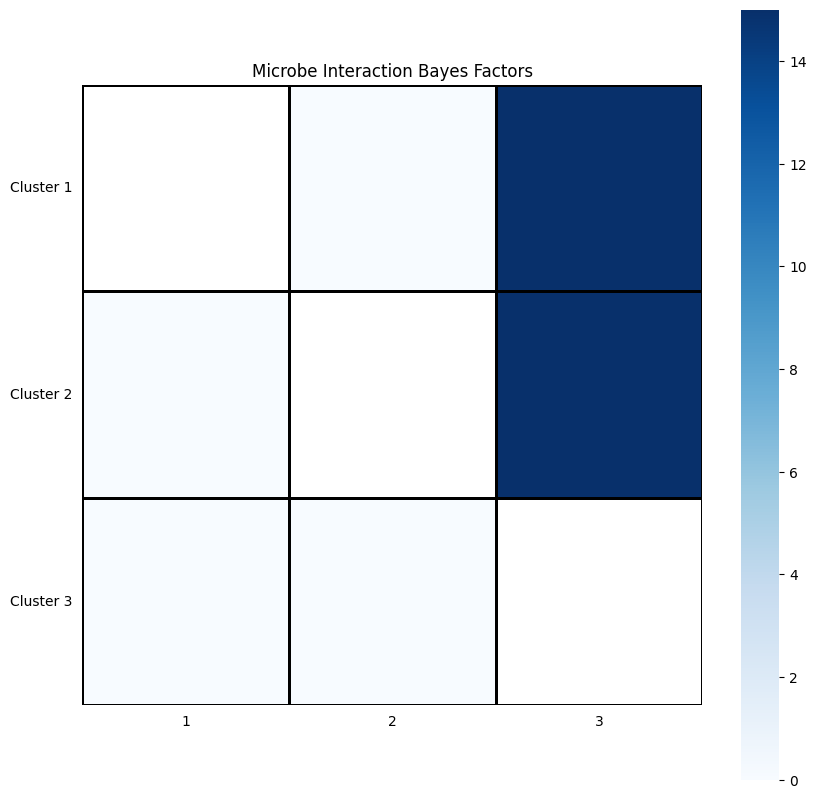

In [26]:
# Plot bayes factors for module-module interactions
clustering_mxcl_lf0 = mcmc_mxcl_lf0.graph[STRNAMES.CLUSTERING_OBJ]
# Generates the bayes factors on an item-item level for the interactions, given the passed in prior {util.py}
bf_taxa_mxcl_lf0 = md2.generate_interation_bayes_factors_posthoc(   # Return bayes factors for each of the interactions on an item-item level [np.ndarray((n,n), dtype=float)]
    mcmc_mxcl_lf0                                                   # This is the inference object containing the traces (mdsine2.BaseMCMC)
)
# Condense the interaction matrix M with the cluster assignments in clustering. Assume that the current cluster assignments is what is used {util.py}
bf_clustering_mxcl_lf0 = md2.condense_fixed_clustering_interaction_matrix(  # Return cluster-cluster interaction matrix [np.ndarray((…, n_clusters, n_clusters)]
    bf_taxa_mxcl_lf0,                                                       # Taxon-taxon interaction matrix [np.ndarray((…, n_taxa, n_taxa), dtype=float)]
    clustering=clustering_mxcl_lf0                                          # Clustering object (mdsine2.Clustering)
)

# Visualize the bayes factors
labels = ['Cluster {}'.format(i+1, i+1) for i in range(len(clustering_mxcl_lf0))]
md2.visualization.render_bayes_factors(     # Renders the bayes factors for each of the interactions
    bf_clustering_mxcl_lf0,                 # Square matrix indicating the bayes factors of the interaction (2-dim np.ndarray)
    yticklabels=labels                      # Labels for the y-axis (list of str)
)
plt.show()

## Cross validation Example

### Forward simulate